# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Project_imageGen/project-image_generation

/content/drive/MyDrive/Project_imageGen/project-image_generation


In [3]:
!pwd

/content/drive/MyDrive/Project_imageGen/project-image_generation


In [4]:
pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 15.9 MB/s eta 0:00:00


In [5]:
#Importing
import os
import random
import copy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import display
import numpy as np
import torch

import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import uuid

import ignite
from ignite.metrics import FID

from modules import UNet
from modules import UNet_2xUD
from modules import UNet_2xUD_halfchannels


seed = 449
random.seed(seed)
torch.manual_seed(seed)
num_images = 1000
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [10]:
#import diffusion utilities and UNET
from diffusion import diffusion_process, denoise_net, diff_model
from modules import UNet_conditional

In [8]:
torch.cuda.is_available()

True

In [9]:
def view_some_images(num_images, output_folder):
  to_tensor = transforms.ToTensor()
  for i in range(num_images):
    image = Image.open(os.path.join(output_folder, f"{i}.png"))
    image_tensor = to_tensor(image)
    plt.figure()
    plt.imshow(np.transpose(image_tensor, (1, 2, 0)))

In [11]:
def save_images(images, path, **kwargs):
    # grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = images.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

In [82]:
def imshow(img, title="", unnormalize="True"):
    if unnormalize:
      img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.figure(figsize=(4,4))
    plt.title(title)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

# Add test dataset and images

In [13]:
batch_size = 1
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified


### Add Cats

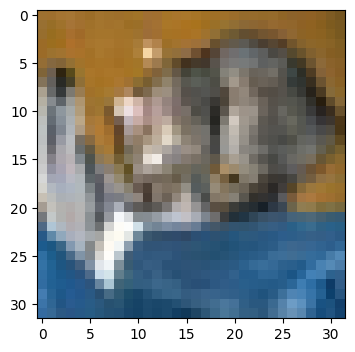

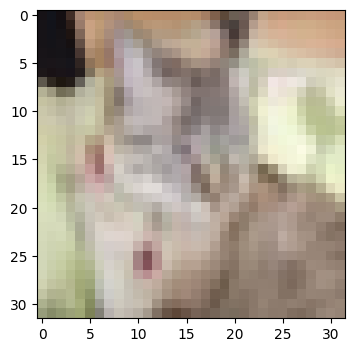

In [17]:
cat_idxs = np.where((np.array(testset.targets) == 3))[0]
catset = torch.utils.data.Subset(testset, cat_idxs)
catloader = torch.utils.data.DataLoader(catset, batch_size=batch_size, shuffle=False, num_workers=2)
iterator = iter(catloader)
images, _ = next(iterator)
imshow(torchvision.utils.make_grid(images.squeeze()))
images, _ = next(iterator)
imshow(torchvision.utils.make_grid(images.squeeze()))

In [18]:
l = len(catloader)
print(l)

1000


In [19]:
import shutil

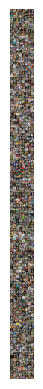

In [20]:
test_folder = "CATtest_images"
output_folder = os.path.join("output/imagesCond_FID/", test_folder)
if os.path.exists(output_folder):
  shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)

img_grid_images = []
for i, (images, _) in enumerate(catloader):
  images = images.squeeze()
  if i<1000:
    images = images/2 + 0.5
    img_grid_images.append(images)
    image_path = os.path.join(output_folder, f"{i}.png")
    save_image(images, image_path)

img_grid = torchvision.utils.make_grid(img_grid_images)
ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()

In [172]:
print(len([name for name in os.listdir(os.path.join("./output/imagesCond_FID/CATtest_images"))]))

1000


### Add Frogs

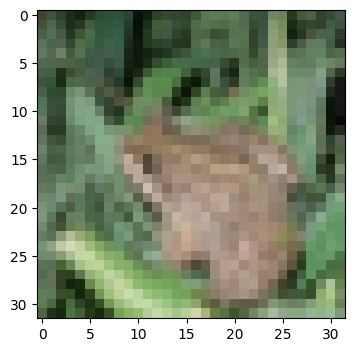

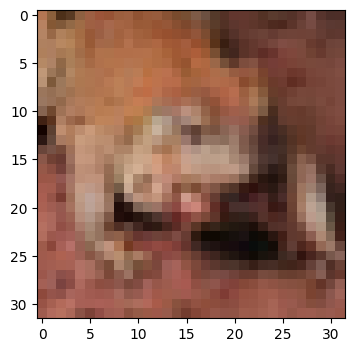

In [31]:
frog_idxs = np.where((np.array(testset.targets) == 6))[0]
frogset = torch.utils.data.Subset(testset, frog_idxs)
frogloader = torch.utils.data.DataLoader(frogset, batch_size=batch_size, shuffle=False, num_workers=2)
iterator = iter(frogloader)
images, _ = next(iterator)
imshow(torchvision.utils.make_grid(images.squeeze()))
images, _ = next(iterator)
imshow(torchvision.utils.make_grid(images.squeeze()))

In [23]:
l = len(frogloader)
print(l)

1000


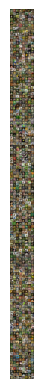

In [25]:
test_folder = "FROGtest_images"
output_folder = os.path.join("output/imagesCond_FID/", test_folder)
if os.path.exists(output_folder):
  shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)

img_grid_images = []
for i, (images, _) in enumerate(frogloader):
  images = images.squeeze()
  if i<1000:
    images = images/2 + 0.5
    img_grid_images.append(images)
    image_path = os.path.join(output_folder, f"{i}.png")
    save_image(images, image_path)

img_grid = torchvision.utils.make_grid(img_grid_images)
ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()

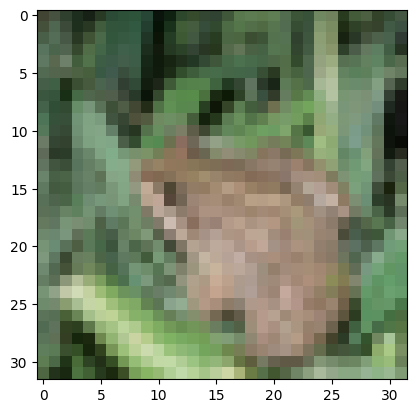

In [27]:
view_some_images(1, "output/imagesCond_FID/FROGtest_images")

In [26]:
print(len([name for name in os.listdir(os.path.join("./output/imagesCond_FID/FROGtest_images"))]))

1000


# Saving conditional diffusion images

### Setup Diffusion

In [73]:
batch_size = 128
image_size = 32

#number of time steps in diffusion process
T = 1000

#beta schedule for the forward process
beta_0 = .0001
beta_T = .02


num_epochs = 1000
lr = 0.0003
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [74]:
net = UNet_conditional(num_classes = 10, device = device)

dif_proc = diffusion_process(T, beta_0, beta_T)
denoising_net = denoise_net(dif_proc, net)

model = diff_model(dif_proc, denoising_net, device = device)

In [79]:

path = "models/ConditionalDiffusion/1024ep-16batch-3e4kr-UNet_conditional-cosine/ckpt.pt"
model.denoiser.net.to(device)
if torch.cuda.is_available():
  model.denoiser.net.load_state_dict(torch.load(path))
else:
  model.denoiser.net.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

In [142]:
def sample_diffusion(class_value, number_images, model, batch_number):

  class_label = torch.tensor([class_value])
  noise = torch.randn(3,32,32)
  batch_size = number_images
  device = "cuda"

  model.denoiser.net.eval()

  with torch.no_grad():
              im = torch.randn((batch_size, 3, 32, 32)).to(device)
      
              for i in reversed(range(model.T)):
                  if i > 1:
                      z = torch.randn_like(im).to(device)
                  else:
                      z = torch.zeros(im.size()).to(device)
                  y = class_label
                  t = (torch.ones(batch_size)*i).long()
                  alpha = (1 - model.dif_proc.variance_schedule[t]).view(-1,1,1,1).to(device)
                  alpha_bar = (1 - model.dif_proc.forward_var(t)).view(-1,1,1,1).to(device)
                  sigma = torch.sqrt(1-alpha) #this is a choice - see section 3.2 of Ho et al

                  pred_noise = model.denoiser.net(im, t.to(device), y.to(device))

                  im = 1/torch.sqrt(alpha)*(im - ((1-alpha)/torch.sqrt(1-alpha_bar))*pred_noise) + sigma*z

                  progress = ((T-i + 1)) / T  # Calculate the progress as a percentage
                  if (i + 1) % (T // 10) == 0:  # Print at every 10% interval
                      print(f"Progress{batch_number}: {int(progress * 100)}%") 

              im = (torch.clamp(im, -1, 1)+1)/2
              im = (im*255).type(torch.uint8)
              return im

### Frog images

In [ ]:

folder_name = "frog_images"

image_batches = []
for i in range(10):
  iarr = []
  image_batches.append(sample_diffusion(class_value=6, number_images = 100, model=model, batch_number=i))
images_batches = tuple(image_batches)
sampled_images = torch.cat(image_batches, dim=0)
img_grid = torchvision.utils.make_grid(sampled_images)

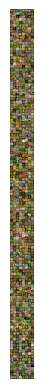

In [148]:
output_folder = os.path.join("output/imagesCond_FID/", folder_name)
if os.path.exists(output_folder):
  shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)

# Save each image individually
for i, image in enumerate(sampled_images):
    if i<num_images:
      #print(image)
      image_path = os.path.join(output_folder, f"{i}.png")
      save_images(image, image_path)
    """
    if i<5:
      plt.figure()
      plt.imshow(image.permute(1,2,0).to('cpu').numpy())
    """

# Display the image grid
img_grid = torchvision.utils.make_grid(sampled_images)
ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()


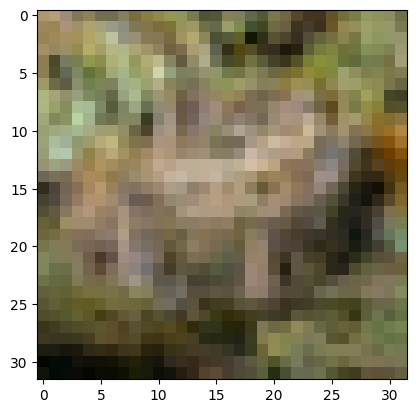

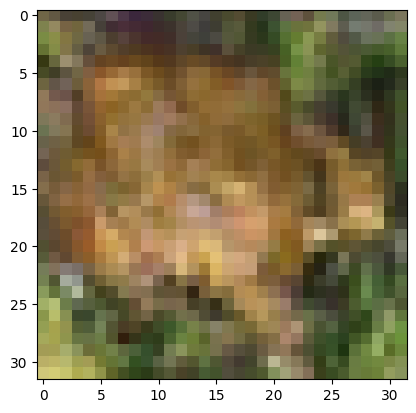

In [152]:
view_some_images(2, "output/imagesCond_FID/frog_images")

In [153]:
print(len([name for name in os.listdir("output/imagesCond_FID/frog_images")]))

1000


### Cat images

In [ ]:

folder_name = "cat_diff_images"

image_batches = []
for i in range(10):
  iarr = []
  image_batches.append(sample_diffusion(class_value=3, number_images = 100, model=model, batch_number=i))
images_batches = tuple(image_batches)
sampled_images = torch.cat(image_batches, dim=0)
img_grid = torchvision.utils.make_grid(sampled_images)

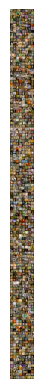

In [166]:
output_folder = os.path.join("output/imagesCond_FID/", folder_name)
if os.path.exists(output_folder):
  shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)

# Save each image individually
for i, image in enumerate(sampled_images):
    if i<num_images:
      #print(image)
      image_path = os.path.join(output_folder, f"{i}.png")
      save_images(image, image_path)
    """
    if i<5:
      plt.figure()
      plt.imshow(image.permute(1,2,0).to('cpu').numpy())
    """

# Display the image grid
img_grid = torchvision.utils.make_grid(sampled_images)
ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()


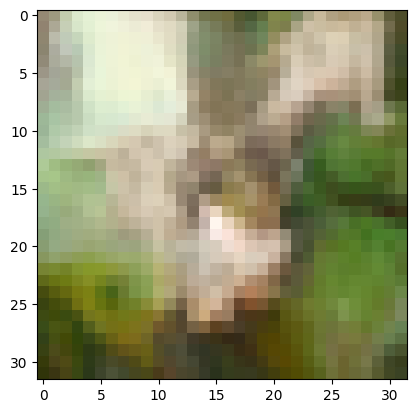

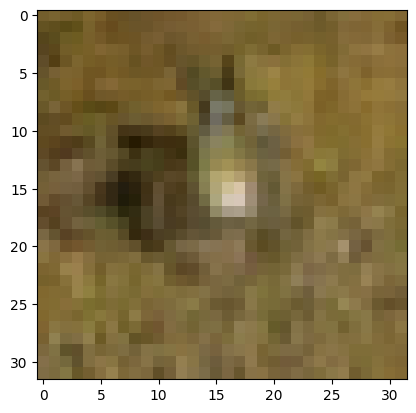

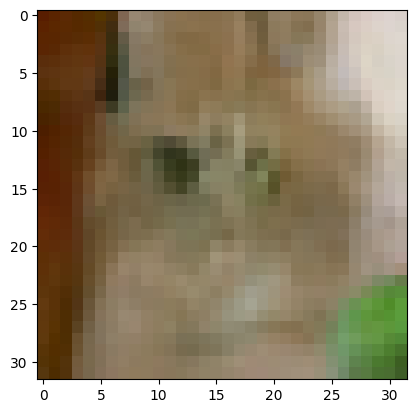

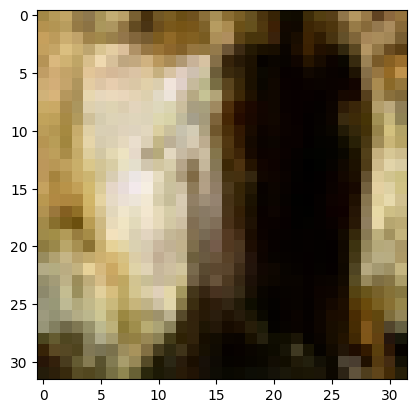

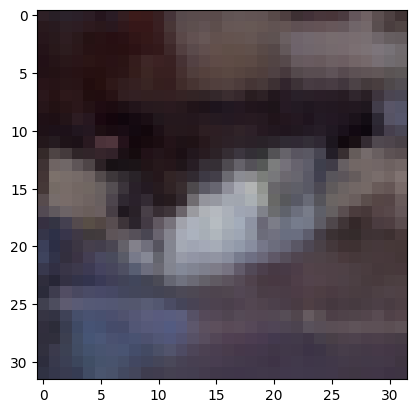

In [169]:
view_some_images(5, "output/imagesCond_FID/cat_diff_images")

In [170]:
print(len([name for name in os.listdir("output/imagesCond_FID/cat_diff_images")]))

1000


# FID for diffusion models

In [171]:
pip install pytorch-fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [173]:
# Cat diffusion
!python -m pytorch_fid output/imagesCond_FID/cat_diff_images output/imagesCond_FID/CATtest_images

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:01<00:00, 51.9MB/s]
100% 20/20 [00:05<00:00,  3.98it/s]
100% 20/20 [00:04<00:00,  4.14it/s]
FID:  102.89442713253936


In [174]:
# Frog diffusion
!python -m pytorch_fid output/imagesCond_FID/frog_images output/imagesCond_FID/FROGtest_images


100% 20/20 [00:04<00:00,  4.03it/s]
100% 20/20 [00:04<00:00,  4.27it/s]
FID:  70.51702490506756


# Saving conditional GAN images